In [1]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
def printattr(name, object):
    print(name)
h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_170_gev.h5', "r")
h5py_file.visititems(printattr)

event_features
event_features/mt
event_features/mx
jet_features
jet_features/barcode
jet_features/btag
jet_features/charge
jet_features/eta
jet_features/event
jet_features/mass
jet_features/num_of_jets
jet_features/phi
jet_features/pt
lepton_features
lepton_features/charge
lepton_features/eta
lepton_features/mass
lepton_features/phi
lepton_features/pid
lepton_features/pt
met_features
met_features/MET
met_features/eta
met_features/phi
met_features/sumet
neutrino_eta
neutrino_eta/spanet
neutrino_eta/target
parton_features
parton_features/eta
parton_features/masks
parton_features/mass
parton_features/parton_barcode
parton_features/pdgid
parton_features/phi
parton_features/pt
spanet
spanet/left_target
spanet/left_target/b
spanet/left_target/detection
spanet/left_target/mask
spanet/reconstructed_top_mass
spanet/right_target
spanet/right_target/b
spanet/right_target/detection
spanet/right_target/mask
spanet/right_target/q1
spanet/right_target/q2
target
target/left_target
target/left_target/b

In [3]:
# The reco_top_mss from ttbar_testing_mass_variation
mass = [170, 171, 172, 173, 174, 175, 176]
reco_dic = {}

for m in mass:
    h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_{}_gev.h5'.format(m), "r")
    cut = np.logical_and(h5py_file['spanet/reconstructed_top_mass'][:]>100, h5py_file['spanet/reconstructed_top_mass'][:]<300)
    reco_dic[m] = h5py_file['spanet/reconstructed_top_mass'][:][cut]

In [4]:
# Fixed the bins for all plots.
bins = np.arange(100, 301, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
tot_event = 100000

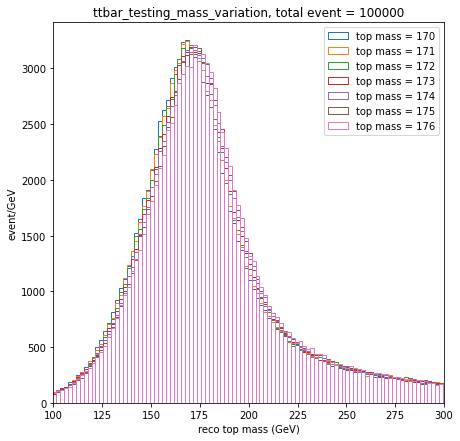

In [5]:
plt.figure(figsize=(7,7))
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist = hist*tot_event/sum(hist)
    plt.bar(bin_edges[:-1]+0.5, hist, edgecolor=colors[i], width=2, color='None', label = 'top mass = {}'.format(m))
plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
plt.xlim(100, 300)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')
plt.show()

In [6]:
h5py_file = h5py.File('ttbar_testing_sm/ttbar_testing_sm.h5', "r")
cut = np.logical_and(h5py_file['spanet/reconstructed_top_mass'][:]>100, h5py_file['spanet/reconstructed_top_mass'][:]<300)
reco = h5py_file['spanet/reconstructed_top_mass'][:][cut]

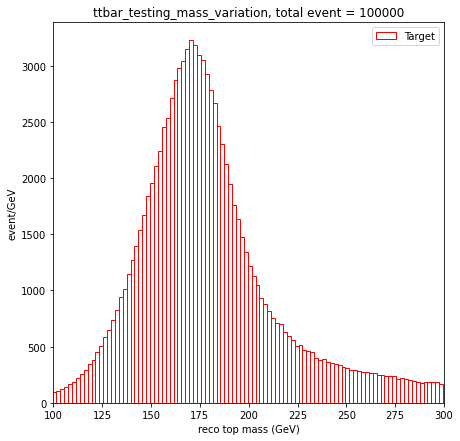

In [7]:
plt.figure(figsize=(7,7))
hist, bin_edges = np.histogram(reco, bins=bins)
hist = hist*tot_event/sum(hist)
plt.bar(bin_edges[:-1]+0.5, hist, edgecolor='red', width=2, color='None', label = 'Target')
plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
plt.xlim(100, 300)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')
plt.show()

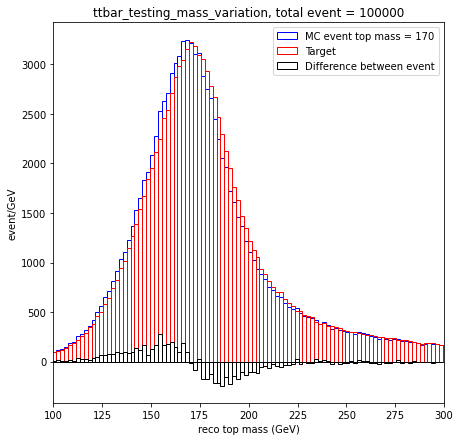

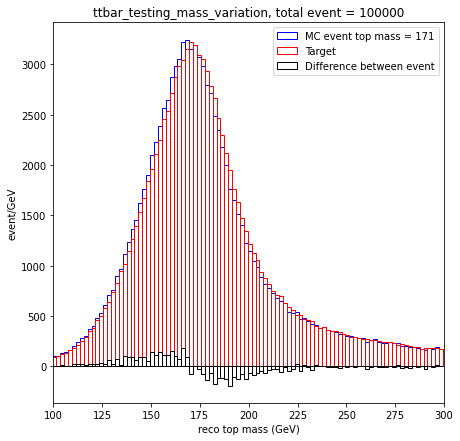

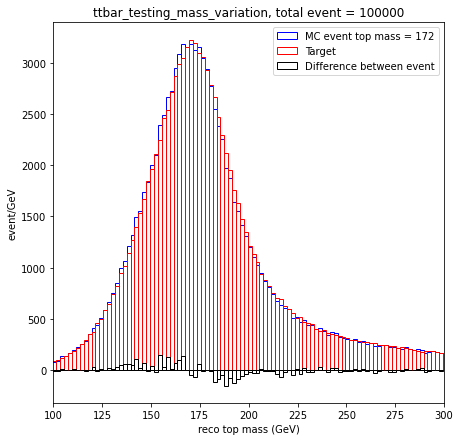

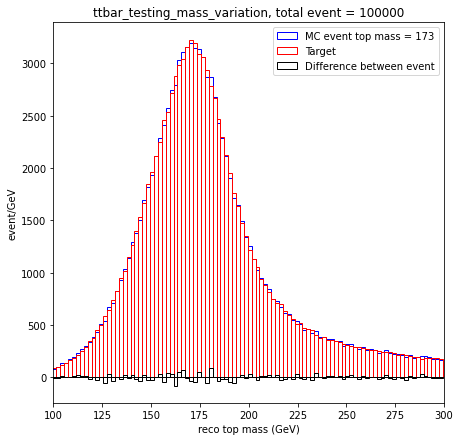

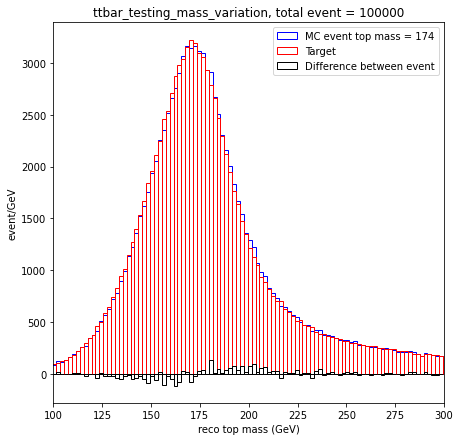

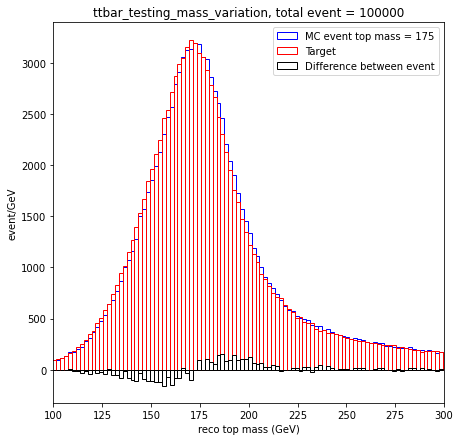

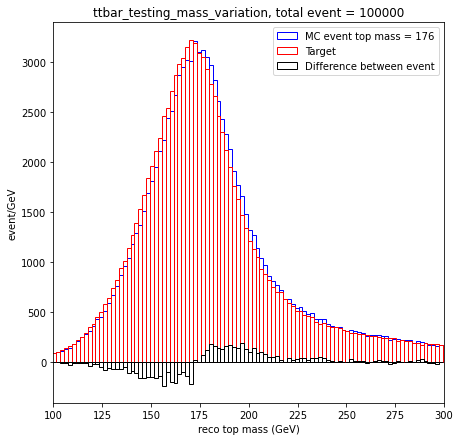

In [8]:
for i, m in enumerate(mass):
    plt.figure(figsize=(7,7))
    hist1, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist1 = hist1*tot_event/sum(hist1)
    hist2, bin_edges = np.histogram(reco, bins=bins)
    hist2 = hist2*tot_event/sum(hist2)
    plt.bar(bin_edges[:-1]+0.5, hist1, edgecolor='blue', width=2, color='None', label = 'MC event top mass = {}'.format(m))
    plt.bar(bin_edges[:-1]+0.5, hist2, edgecolor='red', width=2, color='None', label = 'Target')
    plt.bar(bin_edges[:-1]+0.5, hist1-hist2, edgecolor='black', width=2, color='None', label = 'Difference between event')
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
    plt.show()

In [9]:
def chi2(mt1, mt2): #mt1 is the observation, mt2 is the expected
    n1, bins1 = np.histogram(mt1)
    n2, bins2 = np.histogram(mt2)
    n2 = n2*tot_event/sum(n2)
    chi2_value = 2*sum([n1[i] - n2[i] + n2[i]*np.log(n2[i]/n1[i]) for i in range(len(n1))])
    return chi2_value

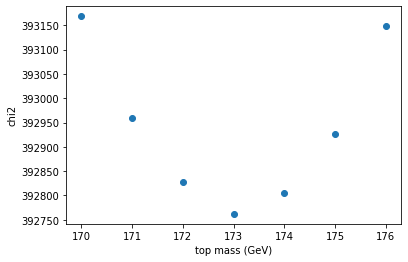

In [10]:
chi2_arr = [chi2(reco, reco_dic[m]) for m in mass]
plt.scatter(mass, chi2_arr)
plt.xlabel('top mass (GeV)')
plt.ylabel('chi2')
plt.show()

In [11]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

In [12]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
def langau(x, lan_size, lan_loc, lan_scale, gau_size, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return lan_size*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + gau_size*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

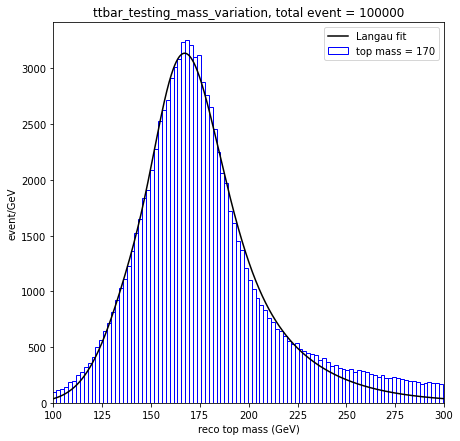

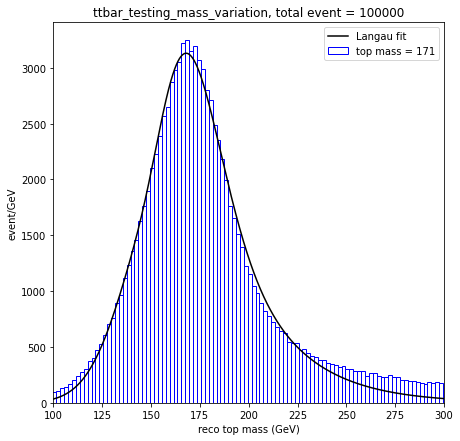

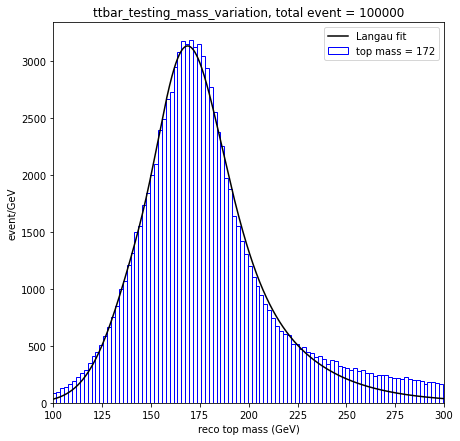

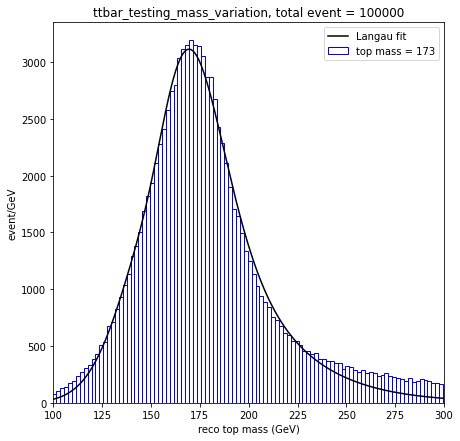

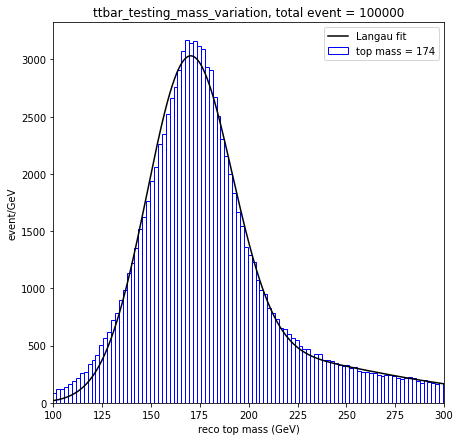

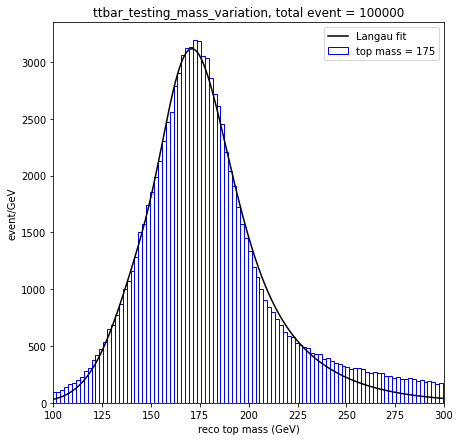

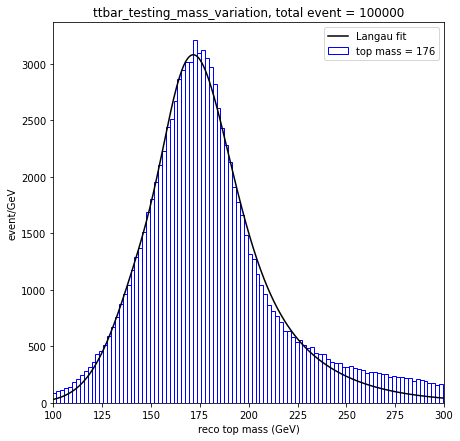

In [13]:
for i, m in enumerate(mass):
    plt.figure(figsize=(7,7))
    hist, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist = hist*tot_event/sum(hist)
    popt, pcov = optimize.curve_fit(langau, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 1000, 1000, 150, 1000, 1000), method="lm")
    x = np.linspace(100, 300, 10000)
    y = langau(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
    plt.plot(x, y, c='k', label='Langau fit')
    plt.bar(bin_edges[:-1]+0.5, hist, edgecolor='blue', width=2, color='None', label = 'top mass = {}'.format(m))
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
    plt.show()

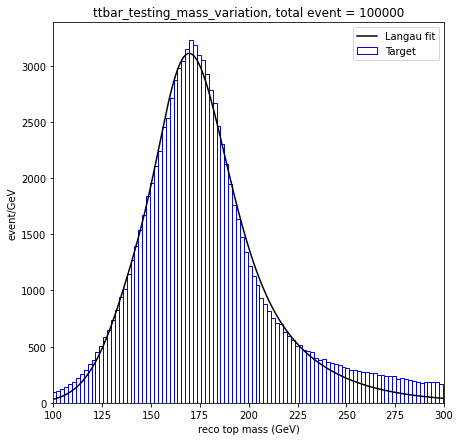

In [14]:
plt.figure(figsize=(7,7))
hist, bin_edges = np.histogram(reco, bins=bins)
hist = hist*tot_event/sum(hist)
popt, pcov = optimize.curve_fit(langau, bin_edges[:-1]+0.5, hist,
                                p0=(150, 1000, 1000, 150, 1000, 1000), method="lm")
x = np.linspace(100, 300, 10000)
y = langau(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
plt.plot(x, y, c='k', label='Langau fit')
plt.bar(bin_edges[:-1]+0.5, hist, edgecolor='blue', width=2, color='None', label = 'Target')
plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
plt.xlim(100, 300)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')
plt.show()